# Predicting Critical Heat Flux

Engineering problems with sophisticated physical phenomena may present extreme challenges to establishing explicit mathematical expressions or building credible input/output causality.
One such engineering problem is the departure from nucleate boiling (DNB) crisis in a two-phase flow boiling system.
The DNB crisis is characterized by a sharp deterioration of the heat transfer coefficient at the heater/coolant interface, as vapor permanently blankets the heated surface, preventing access of supply liquid (which is subcooled or slightly saturated) and potentially leading to a set of cascading component failures.
The corresponding heat flux, or critical heat flux (CHF), is a regulatory limit for commercial pressurized water reactors (PWRs) worldwide.
The goal here is to try some machine learning algorithms to predict the CHF value and evaluate the errors associated.

In [1]:
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
!wget https://raw.githubusercontent.com/isa229/Critical-Heat-Flux-ML/main/data/Data_CHF_Zhao_2020_ATE.csv
data = pd.read_csv("Data_CHF_Zhao_2020_ATE.csv")

--2022-03-09 17:32:56--  https://raw.githubusercontent.com/isa229/Critical-Heat-Flux-ML/main/data/Data_CHF_Zhao_2020_ATE.csv
Resolviendo raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Conectando con raw.githubusercontent.com (raw.githubusercontent.com)[185.199.111.133]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 102988 (101K) [text/plain]
Guardando como: “Data_CHF_Zhao_2020_ATE.csv.3”

Data_CHF_Zhao_2020_ 100%[===================>] 100,57K  --.-KB/s    en 0,1s    

2022-03-09 17:33:07 (958 KB/s) - “Data_CHF_Zhao_2020_ATE.csv.3” guardado [102988/102988]



In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1865 entries, 0 to 1864
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1865 non-null   int64  
 1   author               1865 non-null   object 
 2   geometry             1865 non-null   object 
 3   pressure [MPa]       1865 non-null   float64
 4   mass_flux [kg/m2-s]  1865 non-null   int64  
 5   x_e_out [-]          1865 non-null   float64
 6   D_e [mm]             1865 non-null   float64
 7   D_h [mm]             1865 non-null   float64
 8   length [mm]          1865 non-null   int64  
 9   chf_exp [MW/m2]      1865 non-null   float64
dtypes: float64(5), int64(3), object(2)
memory usage: 145.8+ KB


In [4]:
data.head()

,id,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,1,Inasaka,tube,0.39,5600,-0.1041,3.0,3.0,100,11.3
1,2,Inasaka,tube,0.31,6700,-0.0596,3.0,3.0,100,10.6
2,3,Inasaka,tube,0.33,4300,-0.0395,3.0,3.0,100,7.3
3,4,Inasaka,tube,0.62,6400,-0.1460,3.0,3.0,100,12.8
4,5,Inasaka,tube,0.64,4700,-0.0849,3.0,3.0,100,11.0


Description of some features:

x_e_out: Thermodynamic equilibrium quality. Is defined based on the ratio of the specific enthalpy difference between fluid and saturated liquid to the latent heat of phase change. A negative value corresponds to sub-cooled fluids, and a positive value corresponds to super-heated vapors.

D_e: Equivalent diameter. The equivalent diameter is the diameter of a circular duct or pipe that gives the same pressure loss as a rectangular duct or pipe.

D_h: Heated diameter.

length: Heated length.

In [5]:
numeric_columns = ["pressure [MPa]", "mass_flux [kg/m2-s]", "x_e_out [-]", "D_e [mm]", "D_h [mm]", "length [mm]"]

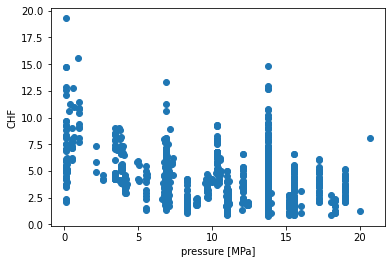

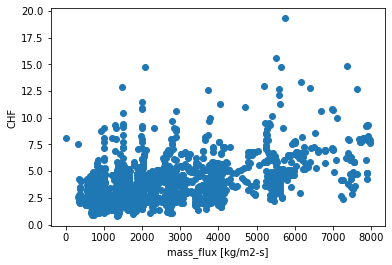

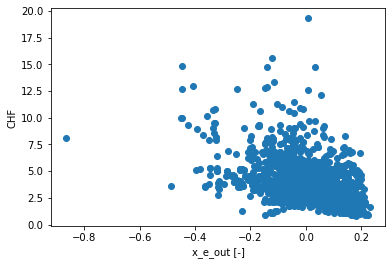

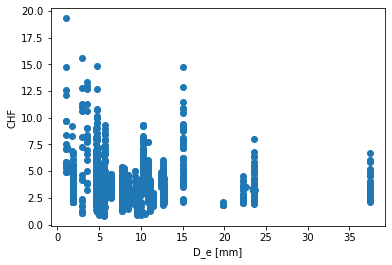

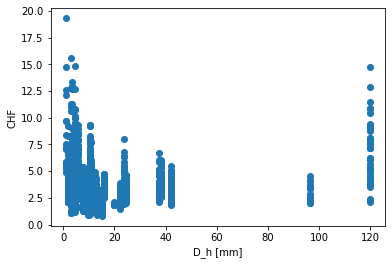

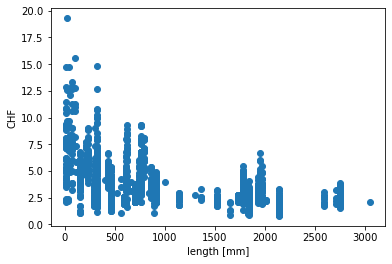

In [6]:
for column in numeric_columns:
    fig, ax = plt.subplots()
    ax.scatter(data[column], data["chf_exp [MW/m2]"])
    ax.set_xlabel(column)
    ax.set_ylabel("CHF");

In [7]:
clean_data = data.drop((["id", "author"]), axis =1)

In [8]:
clean_data.head()

,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,tube,0.39,5600,-0.1041,3.0,3.0,100,11.3
1,tube,0.31,6700,-0.0596,3.0,3.0,100,10.6
2,tube,0.33,4300,-0.0395,3.0,3.0,100,7.3
3,tube,0.62,6400,-0.1460,3.0,3.0,100,12.8
4,tube,0.64,4700,-0.0849,3.0,3.0,100,11.0


In [9]:
dummy = pd.get_dummies(clean_data["geometry"])
dummy.head()

,annulus,plate,tube
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1


In [10]:
clean_data = clean_data.merge(dummy, left_index= True, right_index = True)
clean_data.drop("geometry", axis = 1, inplace = True)

In [11]:
clean_data.head()

,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2],annulus,plate,tube
0,0.39,5600,-0.1041,3.0,3.0,100,11.3,0,0,1
1,0.31,6700,-0.0596,3.0,3.0,100,10.6,0,0,1
2,0.33,4300,-0.0395,3.0,3.0,100,7.3,0,0,1
3,0.62,6400,-0.1460,3.0,3.0,100,12.8,0,0,1
4,0.64,4700,-0.0849,3.0,3.0,100,11.0,0,0,1


In [12]:
clean_data.describe()

,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2],annulus,plate,tube
count,1865.000000,1865.000000,1865.000000,1865.000000,1865.000000,1865.000000,1865.000000,1865.000000,1865.000000,1865.000000
mean,10.010949,2862.647721,0.016179,9.417212,16.167721,911.340483,3.854638,0.202681,0.025737,0.771582
std,4.282715,1656.412247,0.117575,6.333807,21.182870,726.718974,1.985535,0.402105,0.158393,0.419926
min,0.100000,0.000000,-0.866700,1.000000,1.000000,10.000000,0.800000,0.000000,0.000000,0.000000
25%,6.890000,1519.000000,-0.048300,5.600000,5.600000,432.000000,2.400000,0.000000,0.000000,1.000000
50%,10.340000,2590.000000,0.024400,8.500000,10.300000,625.000000,3.500000,0.000000,0.000000,1.000000
75%,13.790000,3933.000000,0.100600,11.100000,15.200000,1778.000000,4.800000,0.000000,0.000000,1.000000
max,20.680000,7975.000000,0.232000,37.500000,120.000000,3048.000000,19.300000,1.000000,1.000000,1.000000


In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X = clean_data.drop("chf_exp [MW/m2]", axis = 1)
y = clean_data["chf_exp [MW/m2]"]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Evaluation of 6 different models: Linear Regression, Lasso, Ridge, Decision Tree Regressor, Random Forest Regressor, Gradient Boosting Regressor

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

<class 'sklearn.linear_model._base.LinearRegression'>


Evaluation of errors for model LinearRegression() 

The MSE is 1.24176461870148
The RMSE is 1.114344928063784
The r2_score is 0.7214108471091305




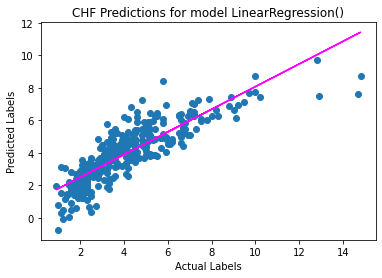

<class 'sklearn.linear_model._coordinate_descent.Lasso'>


Evaluation of errors for model Lasso() 

The MSE is 2.247293792070492
The RMSE is 1.499097659283908
The r2_score is 0.49582097573007455




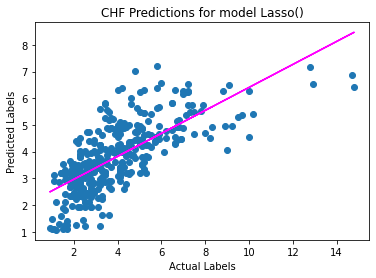

<class 'sklearn.linear_model._ridge.Ridge'>


Evaluation of errors for model Ridge() 

The MSE is 1.25237376769971
The RMSE is 1.1190950664263113
The r2_score is 0.7190306908477928




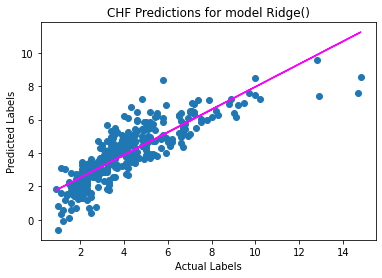

<class 'sklearn.tree._classes.DecisionTreeRegressor'>


Evaluation of errors for model DecisionTreeRegressor() 

The MSE is 0.8985254691689009
The RMSE is 0.9479058334923891
The r2_score is 0.7984163459509777




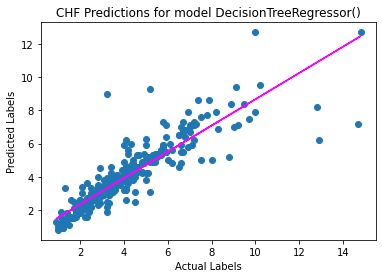

<class 'sklearn.ensemble._forest.RandomForestRegressor'>


Evaluation of errors for model RandomForestRegressor() 

The MSE is 0.5630248284182302
The RMSE is 0.7503498040369107
The r2_score is 0.8736857149549135




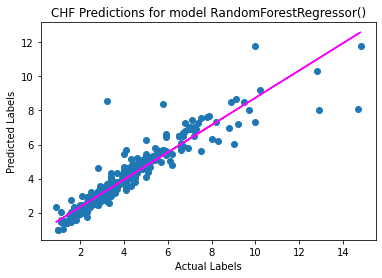

<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>


Evaluation of errors for model GradientBoostingRegressor() 

The MSE is 0.561020133468551
The RMSE is 0.749012772567031
The r2_score is 0.87413546707333




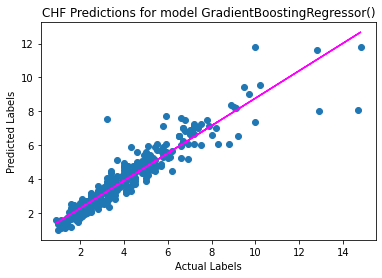

In [17]:
list_of_models = [LinearRegression, Lasso, Ridge, DecisionTreeRegressor, RandomForestRegressor, GradientBoostingRegressor]

for model in list_of_models:
  print(model)
  model = model()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  print("\n")

  print("Evaluation of errors for model {} \n".format(model))
  MSE = mean_squared_error(y_test, y_pred)
  RMSE = np.sqrt(MSE)
  R2 = r2_score(y_test, y_pred)

  print("The MSE is {}\nThe RMSE is {}\nThe r2_score is {}".format(MSE, RMSE, R2))
    
  # Plot predicted vs actual
  plt.scatter(y_test, y_pred)
  plt.xlabel('Actual Labels')
  plt.ylabel('Predicted Labels')
  plt.title('CHF Predictions for model {}'.format(model))
  # overlay the regression line
  z = np.polyfit(y_test, y_pred, 1)
  p = np.poly1d(z)
  plt.plot(y_test,p(y_test), color='magenta')
  print("\n")
  plt.show();

### Hyerparameter tuning with RandomizedSearchCV for Random Forest

In [21]:
from sklearn.model_selection import RandomizedSearchCV

rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"]}

rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1),
                              param_distributions=rf_grid,
                              n_iter=100, 
                              cv=5,
                              verbose=True,
                              random_state = 45)

rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1), n_iter=100,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   random_state=45, verbose=True)

In [22]:
# The best model hyperparameters are:
rs_model.best_params_

{'n_estimators': 40,
 'min_samples_split': 6,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None}

#### Training RandomForest with the best hyperparamters

In [23]:
ideal_model = RandomForestRegressor(n_estimators= 40,
                                  min_samples_split= 6,
                                  min_samples_leaf= 1,
                                  max_features= "sqrt",
                                  max_depth= None,
                                  random_state = 45)


ideal_model.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', min_samples_split=6, n_estimators=40,
                      random_state=45)

In [32]:
def show_scores(model):
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Test MAE": mean_absolute_error(y_test, test_preds),
              "Training MSE": mean_squared_error(y_train, train_preds),
              "Test MSE": mean_squared_error(y_test, test_preds),
              "Training R^2": r2_score(y_train, train_preds),
              "Test R^2": r2_score(y_test, test_preds)}
    return scores

In [33]:
show_scores(ideal_model)

{'Training MAE': 0.2125823953214829,
 'Test MAE': 0.3932508238893963,
 'Training MSE': 0.14176635316674077,
 'Test MSE': 0.5886732625960671,
 'Training R^2': 0.962769990459805,
 'Test R^2': 0.8679315040175357}

#### Feature importance                                                                                                                                                            

In [34]:
def plot_features(columns, importances):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"], df["feature_importances"])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

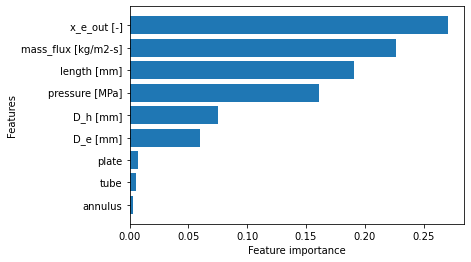

In [35]:
plot_features(X_train.columns, ideal_model.feature_importances_)

We can see that the geometry of the reactors has little importance in this case. With this information we can make some adjustments in the model.